In [29]:
import numpy as np
from PIL import Image
import os

In [30]:
from datetime import datetime
from tqdm import tqdm
import numpy as np
import random, os, sys, torch, cv2, warnings
from glob import glob
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

prj_dir = os.path.dirname('/scratch/network/mk8574/change_detection_challenge/baseline_mk/')

from modules.utils import load_yaml, save_yaml, get_logger
from modules.scalers import get_image_scaler
from modules.datasets import SegDataset
from models.utils import get_model


def colorize_mask(mask, colors):
    # Colorize the mask based on the provided colors
    # `colors` should be a dictionary mapping each class to a BGR color
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for cls, color in colors.items():
        colored_mask[mask == cls] = color
    
    return colored_mask

def overlay_mask_on_image(image, mask, alpha=0.5):
    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, alpha, mask, 1 - alpha, 0)
    return overlay

# Define colors for each class in BGR format
class_colors = {
    0: [0, 0, 0],        # Class 0: Black
    1: [255, 255, 0],      # Class 1: Lightblue
    2: [0, 255, 255],      # Class 2: Yellow
    3: [255, 0, 255],      # Class 3: Pink
}

In [31]:
"""
Train classifier 
"""
from datetime import datetime
from time import time
import numpy as np
import shutil, random, os, sys, torch
from glob import glob
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

prj_dir = '/scratch/network/mk8574/change_detection_challenge/baseline_mk'
sys.path.append(prj_dir)
# checkpoint_path = "results/train/ ... /model.pt"

from modules.utils import load_yaml, get_logger
from modules.metrics import get_metric_function
from modules.earlystoppers import EarlyStopper
from modules.losses import get_loss_function
from modules.optimizers import get_optimizer
from modules.schedulers import get_scheduler
from modules.scalers import get_image_scaler
from modules.datasets import SegDataset
from modules.recorders import Recorder
from modules.trainer import Trainer
from models.utils import get_model
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base import SegmentationModel

from PIL import Image
     

def decompose(img):
    B, C, W, H = img.shape

    half_height = H // 2
    return img[:, :, :, :half_height], img[:, :, :, half_height:]

class Difference_Model(SegmentationModel):       
    def __init__(self):
        super().__init__()
        config_path = os.path.join('./config', 'train.yaml')
        config = load_yaml(config_path)

        os.environ['CUDA_VISIBLE_DEVICES'] = str(config['gpu_num'])
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = smp.DeepLabV3Plus(classes=4 , # config['n_classes'] 
                encoder_name=config['encoder'],
                encoder_weights=config['encoder_weight'],
                activation=config['activation']).to(device)
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.segmentation_head = model.segmentation_head
        self.classification_head = model.classification_head
        
        return
        
    def forward(self, x):
        # # split x into two
        a, b = decompose(x)
        # process as input
        a = self.encoder(a)
        b = self.encoder(b)

        # compute differences
        features = list(a[i] - b[i] for i in range(len(a)))

        # process as output
        result = self.decoder(*features)
        
        masks = self.segmentation_head(result)
        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels
            
        return masks


In [32]:
def predict_image(img_id = '2015_DMG_1LB_000066'):
    train_serial = '20231118_234744'
    
    config = load_yaml(os.path.join(prj_dir, 'config', 'predict.yaml'))
    train_config = load_yaml(os.path.join(prj_dir, 'results', 'train', train_serial, 'train.yaml'))

    #! Set predict serial
    pred_serial = train_serial + '_' + datetime.now().strftime("%Y%m%d_%H%M%S")

    # Set random seed, deterministic
    torch.cuda.manual_seed(train_config['seed'])
    torch.manual_seed(train_config['seed'])
    np.random.seed(train_config['seed'])
    random.seed(train_config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set device(GPU/CPU)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['gpu_num'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create train result directory and set logger
    pred_result_dir = os.path.join(prj_dir, 'results', 'pred', pred_serial)
    pred_result_dir_mask = os.path.join(prj_dir, 'results', 'pred', pred_serial, 'mask')
    os.makedirs(pred_result_dir, exist_ok=True)
    os.makedirs(pred_result_dir_mask, exist_ok=True)


    # Load architecture
    # model = get_model(model_str=train_config['architecture'])
    # model = model(
    #             classes=train_config['n_classes'],
    #             encoder_name=train_config['encoder'],
    #             encoder_weights=train_config['encoder_weight'],
    #             activation=train_config['activation']).to(device)
    model = Difference_Model()
    
    
    #! Load weight
    check_point_path = os.path.join(prj_dir, 'results', 'train', train_serial, 'model.pt')
    check_point = torch.load(check_point_path)
    model.load_state_dict(check_point['model'])

    base_url = os.path.join("/scratch/network/mk8574/change_detection_challenge/data/train")
    filename = img_id + ".png"
    orig_img = cv2.imread(os.path.join(base_url, 'x', filename), cv2.IMREAD_COLOR)
    orig_size = orig_img.shape

    x = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, [train_config['input_width'], train_config['input_height']])
    x = get_image_scaler(train_config['scaler'])(x)
    x = torch.tensor(x.transpose(2, 0, 1)).unsqueeze(0)

    model.eval()

    with torch.no_grad():
        x = x.to(device, dtype=torch.float)
        y_pred = model(x)
        y_pred_argmax = y_pred.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)
        print(y_pred_argmax.shape)
        predicted_mask = cv2.resize(y_pred_argmax, orig_img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

    gt_mask_path = os.path.join(base_url, 'y', filename) # Define `ground_truth_dir` appropriately
    gt_mask = cv2.imread(gt_mask_path, 0) # 0 for grayscale
    
    # If `x` is a tensor, convert it to a numpy array and adjust channels
    if torch.is_tensor(x):
        # Assuming x is a single image, but check if it's a batch
        if len(x.shape) == 4:
            # If it's a batch, take the first image
            x = x[0]

        # Convert to numpy and change channel order
        x = x.permute(1, 2, 0).cpu().numpy()

    print(img_id)
    # Display the images
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    predicted_img = overlay_mask_on_image(orig_img, colorize_mask(predicted_mask, class_colors), alpha=0.5)
    plt.imshow(predicted_img)
    plt.title('Predicted Segmentation')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    gt_img = overlay_mask_on_image(orig_img, colorize_mask(gt_mask, class_colors), alpha=0.5)
    plt.imshow(gt_img)
    # plt.imshow(gt_mask)
    plt.title('Ground Truth Segmentation')
    plt.axis('off')

    plt.show()

In [33]:
import ast

def get_valids(serial_id):
    path = os.path.join("/scratch/network/mk8574/change_detection_challenge/baseline_mk/results/train", serial_id, 'valids')
    
    with open(path, 'r') as file:
        file_content = file.read()
        
    ret = ast.literal_eval(file_content)
    return [os.path.splitext(os.path.basename(x))[0] for x in ret]

In [34]:
id_list = get_valids('20231118_234744')

In [35]:
import random

def sample_n(n, random_seed):
    # Set the random seed
    random.seed(random_seed)

    for id in random.sample(id_list, n):
        predict_image(id)

(256, 240)
2019_KBG_3LB_000168


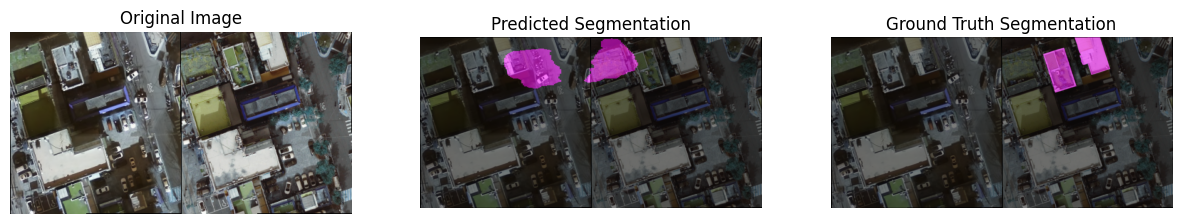

(256, 240)
2017_MPG_2LB_000592


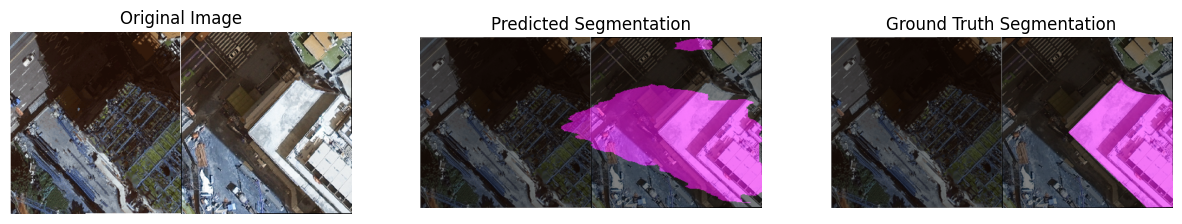

(256, 240)
2017_JLG_2LB_000185


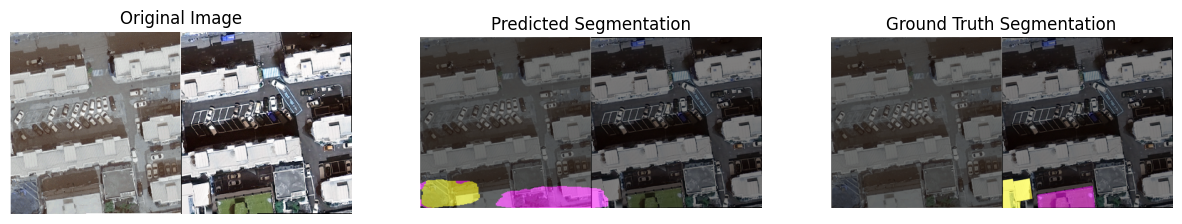

(256, 240)
2019_YSG_3LB_000076


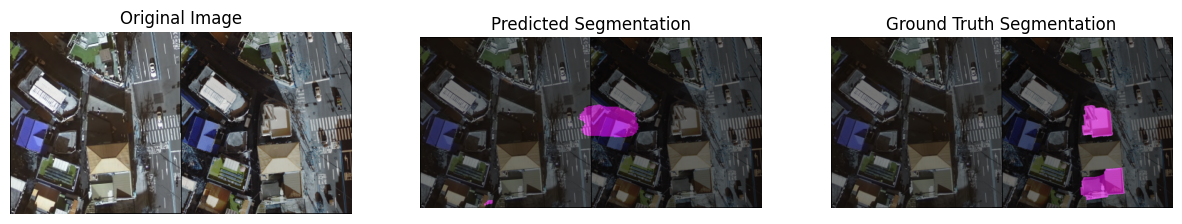

(256, 240)
2015_EPG_JJG_000017


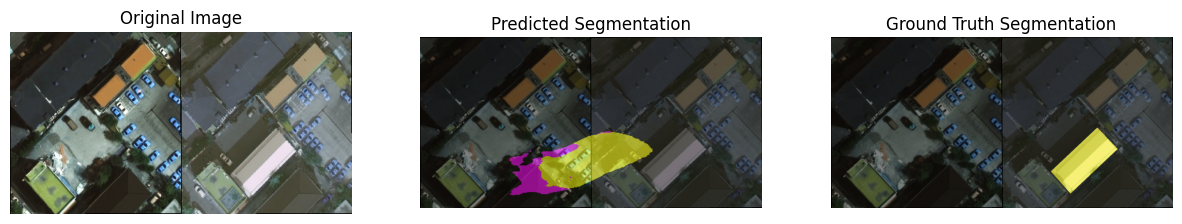

In [36]:
sample_n(5, 3000)

(256, 240)
2015_KSG_2LB_000140


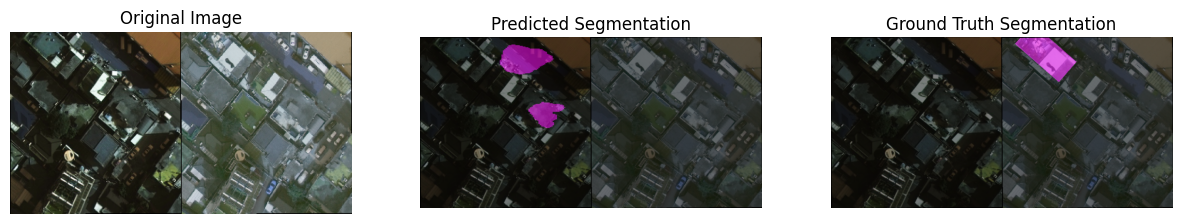

(256, 240)
2019_KDG_3LB_000115


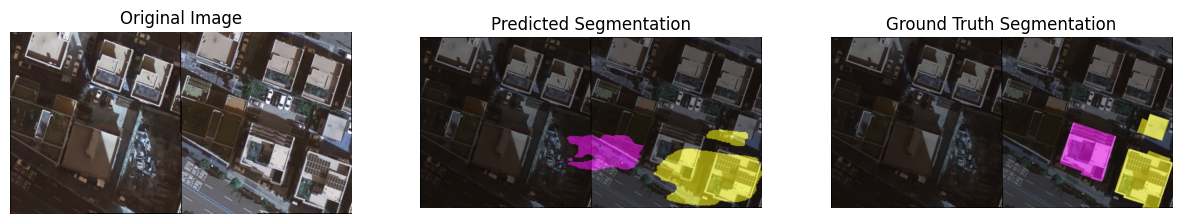

(256, 240)
2017_SCG_1LB_000007


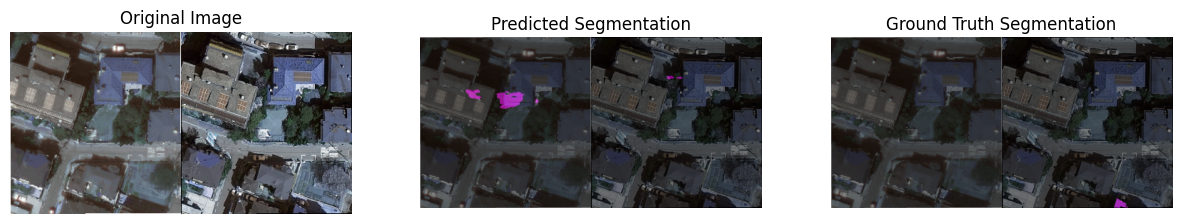

(256, 240)
2017_JLG_3LB_000295


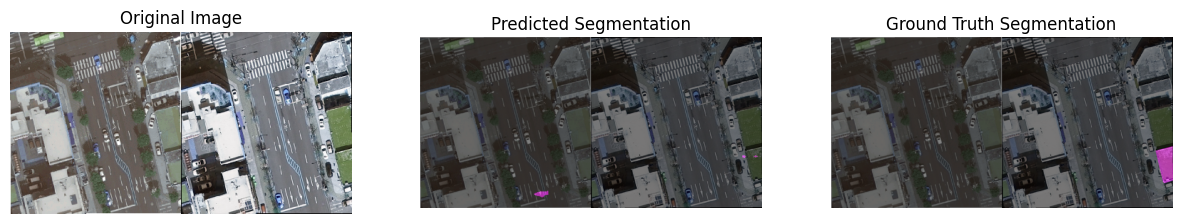

(256, 240)
2017_KSG_2LB_000666


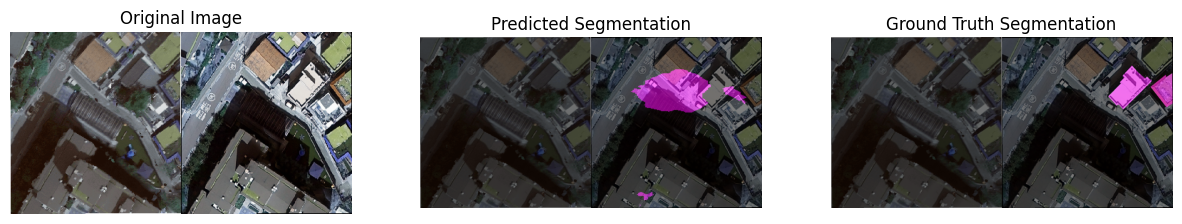

In [37]:
sample_n(5, 3245)

(256, 240)
2019_SDG_3LB_000080


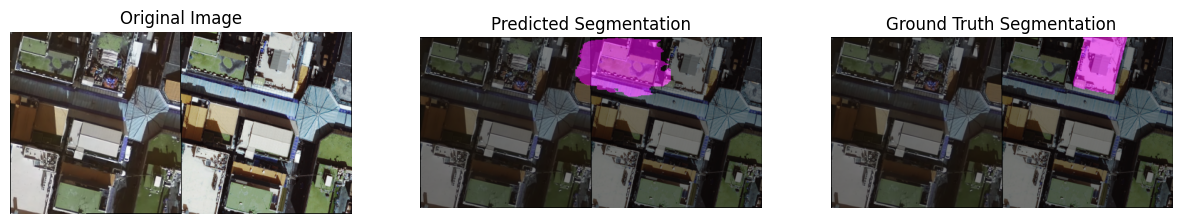

(256, 240)
2017_KRG_JKG_000185


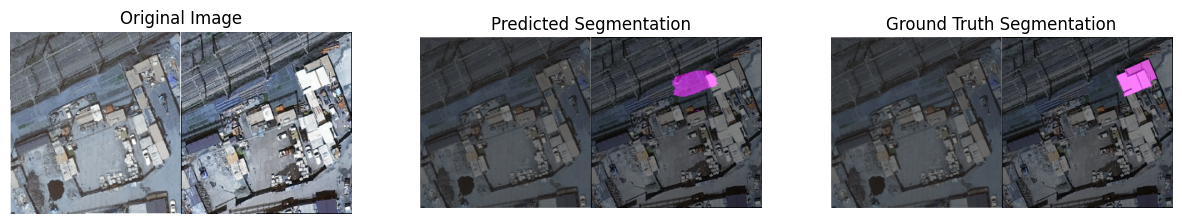

(256, 240)
2017_DJG_2LB_000709


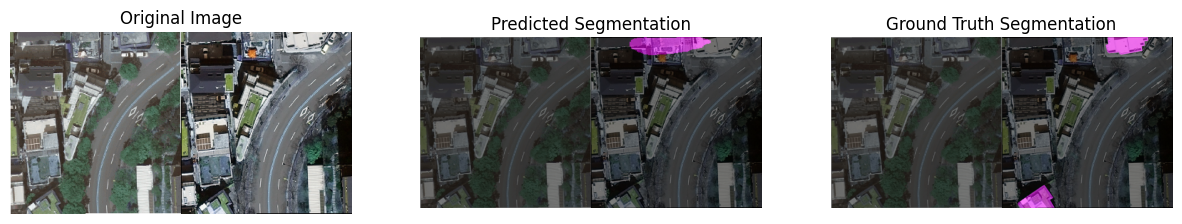

(256, 240)
2017_KNG_1LB_000206


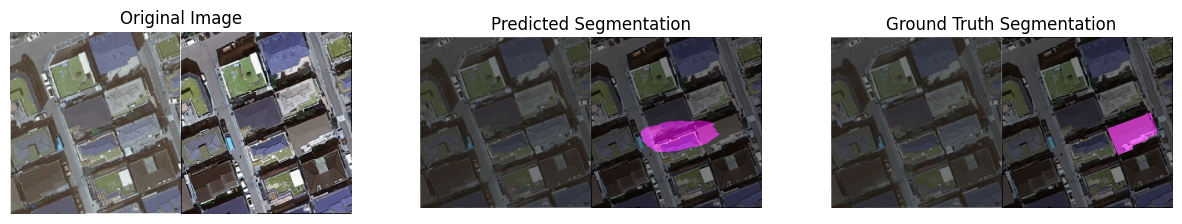

(256, 240)
2017_SMG_2LB_000259


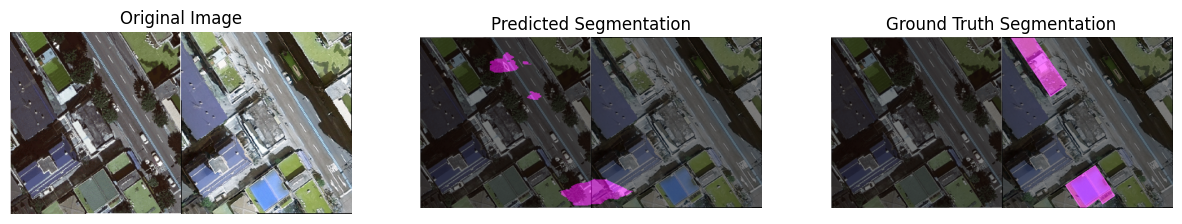

In [38]:
sample_n(5, 789)

(256, 240)
2017_KSG_1LB_000015


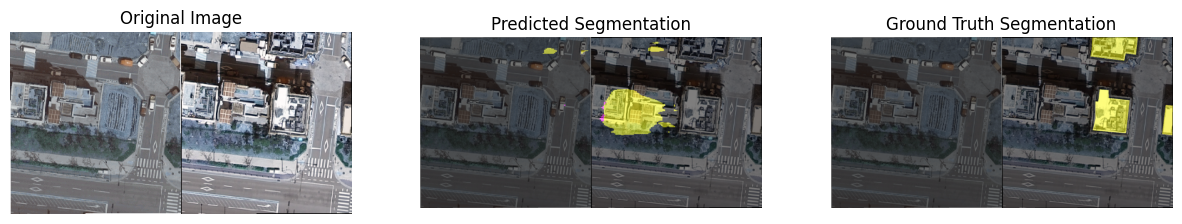

(256, 240)
2016_MPG_SAG_000115


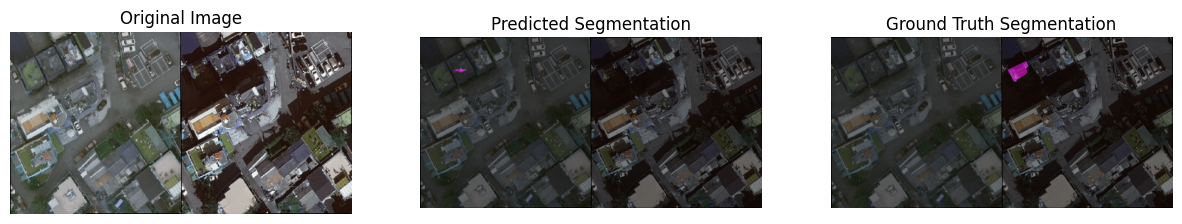

(256, 240)
2018_YDP_JKG_000702


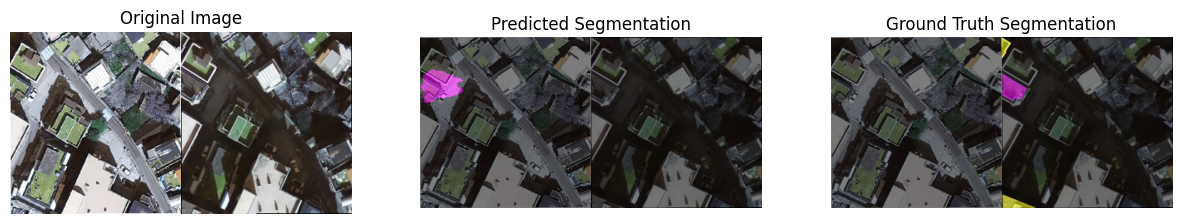

(256, 240)
2015_KSG_1JY_000016


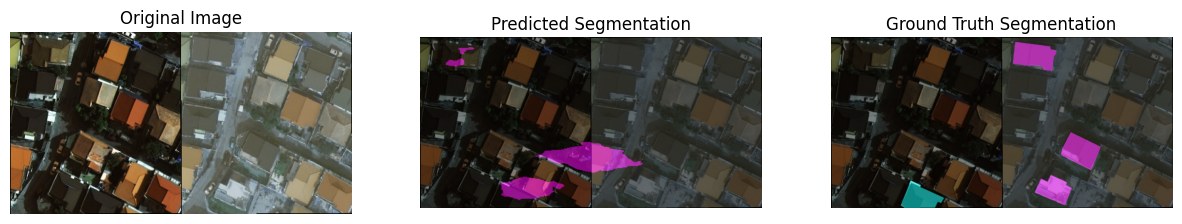

(256, 240)
2019_KBG_3LB_000162


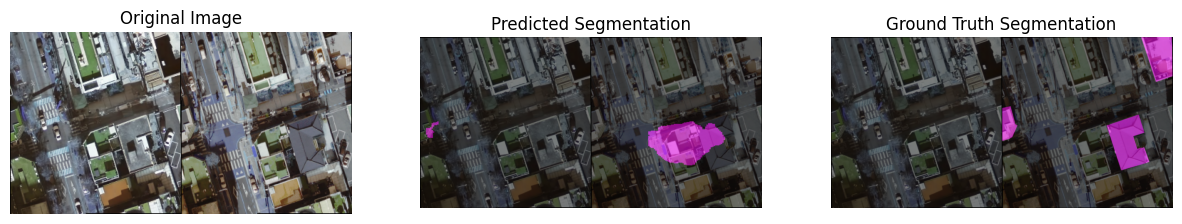

In [39]:
sample_n(5, 23145)